In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [69]:
df=pd.read_csv("data/Pokemon.csv")
df

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


## ***Verify target column balance***

In [70]:
counts = df['Legendary'].value_counts()
counts

Legendary
False    735
True      65
Name: count, dtype: int64

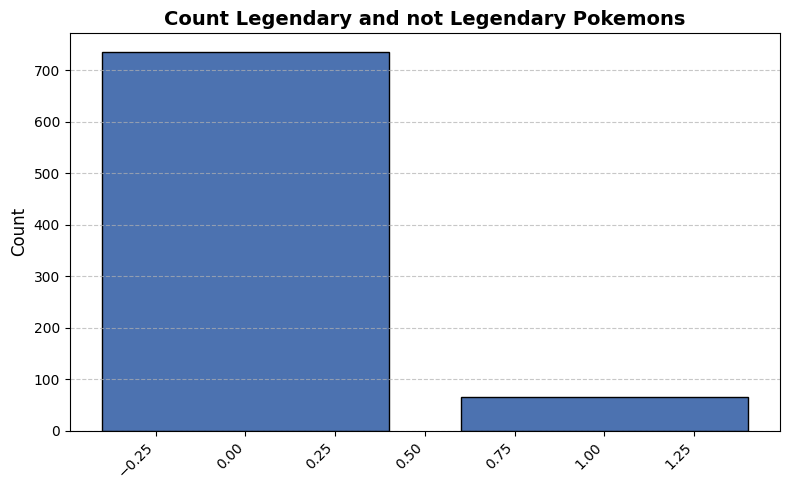

In [71]:

plt.figure(figsize=(8, 5))

plt.bar(counts.index, counts.values, color='#4C72B0', edgecolor='black')

plt.ylabel('Count', fontsize=12)
plt.title('Count Legendary and not Legendary Pokemons', fontsize=14, fontweight='bold')

plt.xticks(rotation=45, ha='right')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### ***When data is so unbalanced training will give better results than it actually is.***
### ***Make sure you balance data especially when you predict something more important:have disease or not,fraud or not fraud***


In [72]:
#Drop unusefull column
df.drop(columns=["#"])

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


### ***Undersampling-simply reduce samples in the majority class so that it matches the minority class***

In [73]:
from sklearn.utils import resample

target_column = "Legendary"
majority_class = df[df[target_column] == df[target_column].value_counts().idxmax()]
minority_class = df[df[target_column] == df[target_column].value_counts().idxmin()]

majority_downsampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42)


#TODO !!!Shuffle the result
df_undersampled = pd.concat([majority_downsampled, minority_class])

df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_undersampled[target_column].value_counts())


Legendary
False    65
True     65
Name: count, dtype: int64


In [74]:
from sklearn.preprocessing import LabelEncoder
def encode_object_columns(df):
    obj_cols = df.select_dtypes(include=["object", "boolean"]).columns
    for col in obj_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
    return df

df = encode_object_columns(df)

### ***Class Weight - give more importance to the minority class during training without changing your data.***

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, weights))
print(class_weights)

model = RandomForestClassifier(
    class_weight=class_weights,
    random_state=42
)
model.fit(X_train, y_train)




{np.int64(0): np.float64(0.5470085470085471), np.int64(1): np.float64(5.818181818181818)}


RandomForestClassifier(class_weight={np.int64(0): np.float64(0.5470085470085471),
                                     np.int64(1): np.float64(5.818181818181818)},
                       random_state=42)

In [76]:
def evaluate_model(model, X_test, y_test, average='binary'):
    y_pred = model.predict(X_test)
    try:
        y_probs = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_probs)
    except AttributeError:
        roc_auc = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average=average)
    rec = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'F1 Score: {f1:.4f}')
    if roc_auc is not None:
        print(f'ROC AUC: {roc_auc:.4f}')

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



Accuracy: 0.9625
Precision: 0.7000
Recall: 0.7000
F1 Score: 0.7000
ROC AUC: 0.9860

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       150
           1       0.70      0.70      0.70        10

    accuracy                           0.96       160
   macro avg       0.84      0.84      0.84       160
weighted avg       0.96      0.96      0.96       160



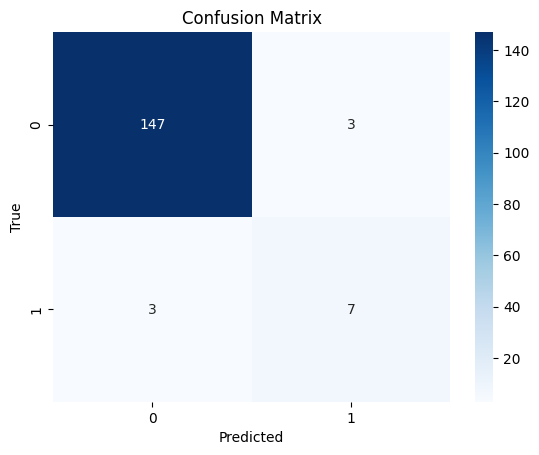

In [77]:
evaluate_model(model, X_test, y_test, average='binary')

#### ***As I said earlier accuracy is very high but Precision, Recall, and F1 Score are moderate (0.70) — this shows the model finds the minority class but not perfectly.***

## ***Oversampling - generate new candidates for minority class***

### **SMOTE** - Creates synthetic samples for the minority class by interpolating between existing samples.



Accuracy: 0.9694
Precision: 1.0000
Recall: 0.9396
F1 Score: 0.9689
ROC AUC: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       145
           1       1.00      0.94      0.97       149

    accuracy                           0.97       294
   macro avg       0.97      0.97      0.97       294
weighted avg       0.97      0.97      0.97       294



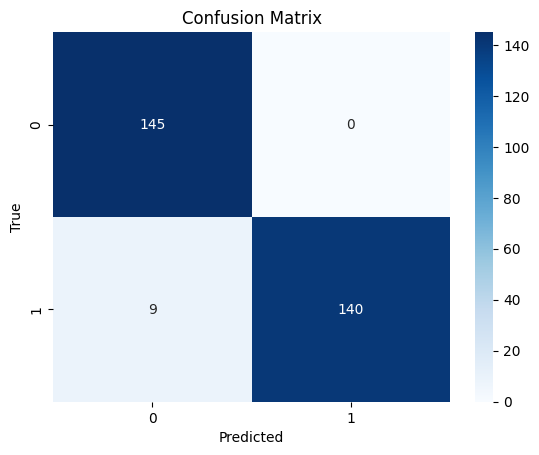

In [78]:
from crucio import SMOTE

smote = SMOTE()
smote_balanced_df = smote.balance(df=df, target=target_column)

X_smote = smote_balanced_df.drop(target_column, axis=1)
y_smote = smote_balanced_df[target_column]

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42
)

evaluate_model(model,X_test=X_test_smote,y_test=y_test_smote)



## **SMOTEENN** - (SMOTE) + (ENN)
### ENN = If sample’s label differs from the majority label of its k nearest neighbor it is removed

Accuracy: 0.9619
Precision: 1.0000
Recall: 0.9231
F1 Score: 0.9600
ROC AUC: 0.9998

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       146
           1       1.00      0.92      0.96       143

    accuracy                           0.96       289
   macro avg       0.96      0.96      0.96       289
weighted avg       0.96      0.96      0.96       289



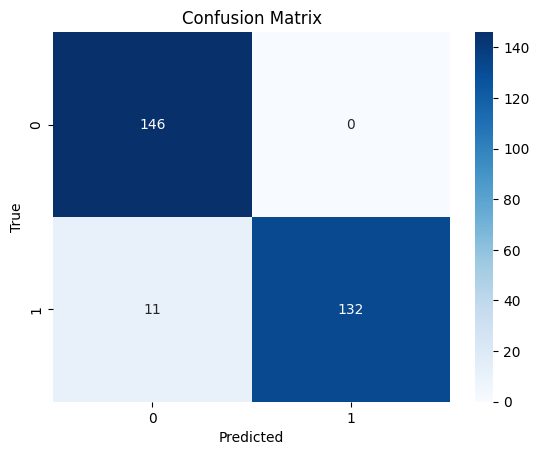

In [79]:
from crucio import SMOTEENN

smoteenn = SMOTEENN()
smoteenn_balanced_df = smoteenn.balance(df=df, target=target_column)

X_smoteenn = smoteenn_balanced_df.drop(target_column, axis=1)
y_smoteenn = smoteenn_balanced_df[target_column]

X_train_smoteenn, X_test_smoteenn, y_train_smoteenn, y_test_smoteenn = train_test_split(
    X_smoteenn, y_smoteenn, test_size=0.2, random_state=42
)

evaluate_model(model,X_test=X_test_smoteenn,y_test=y_test_smoteenn)

### ***TKRKNN - Instead of adding anything, it removes majority class samples that are less important it keeps only those majority samples that are close to or influencing minority samples (based on how often majority points appear in minority samples’ neighbors).***

Accuracy: 0.9966
Precision: 1.0000
Recall: 0.9937
F1 Score: 0.9968
ROC AUC: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       136
           1       1.00      0.99      1.00       158

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



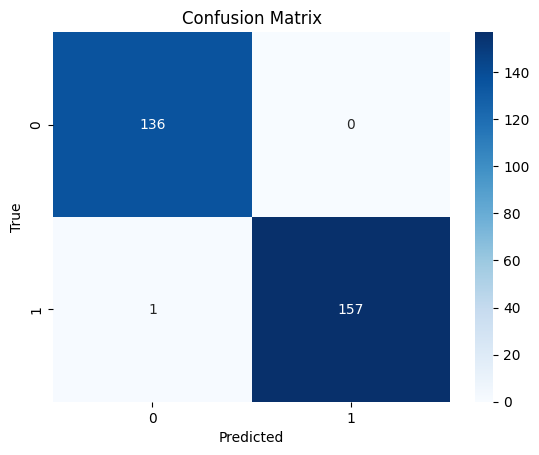

In [80]:
from crucio import TKRKNN

tkrknn = TKRKNN()
tkrknn_balanced_df = tkrknn.balance(df=df, target=target_column)

X_tkrknn = tkrknn_balanced_df.drop(target_column, axis=1)
y_tkrknn = tkrknn_balanced_df[target_column]

X_train_tkrknn, X_test_tkrknn, y_train_tkrknn, y_test_tkrknn = train_test_split(
    X_tkrknn, y_tkrknn, test_size=0.2, random_state=42
)

evaluate_model(model,X_test=X_test_tkrknn,y_test=y_test_tkrknn)

## **Other most used techniques for balancing**

| Technique               | Use When                         | Pros                         | Cons                       |
| ----------------------- | -------------------------------- | ---------------------------- | -------------------------- |
| SMOTE & Variants        | Tabular data, moderate imbalance | Effective, easy to implement | Can create noisy samples   |
| ADASYN                  | Complex minority class           | Focus on hard examples       | Can overfit in some cases  |
| Random Sampling         | Baseline/simple cases            | Simple & fast                | Risk of over/underfitting  |
| Tomek Links / ENN       | Clean data post-oversampling     | Removes noise & overlaps     | Might remove useful points |
| Ensemble Methods        | Complex, high-dimensional data   | Robust, strong performance   | Computationally expensive  |
| Cost-Sensitive Learning | When data changes not allowed    | No data modification         | Requires careful tuning    |


# Common Python Libraries for Imbalanced Class
```python
1. from imblearn.over_sampling import SMOTE, SMOTEENN, SMOTETomek
2. from imblearn.over_sampling import ADASYN
3. from imblearn.over_sampling import RandomOverSampler
   from imblearn.under_sampling import RandomUnderSampler
4. from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
5. from imblearn.under_sampling import ClusterCentroids
6. from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier, BalanceCascade
